In [15]:
pip install geopandas matplotlib shapely contextily


   ---------------------------------------- 0.0/25.5 MB ? eta -:--:--
   ----------------- ---------------------- 11.3/25.5 MB 54.2 MB/s eta 0:00:01
   ----------------------------------- ---- 22.5/25.5 MB 52.9 MB/s eta 0:00:01
   ---------------------------------------- 25.5/25.5 MB 47.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [16]:
import geopandas as gpd
import pandas as pd
from shapely import wkt
import matplotlib.pyplot as plt
import glob
import contextily as ctx

In [3]:
# ----------------------------------------
# 1. Leer y unir los CSVs con rutas (por CCAA)
# ----------------------------------------

csv_files = glob.glob(r"C:\Users\maria.b.calvo\Documents\Personal\Hackathon GenAI\hackathon-repo\Hackathon-PNAV\1. Obtención Y Procesado de Datos\Rutas\Rutas_Raw/*.csv")
rutas_list = []

for file in csv_files:
    df = pd.read_csv(file)
    df["geometry"] = df["geometry"].apply(wkt.loads)
    rutas_list.append(gpd.GeoDataFrame(df, geometry="geometry"))

rutas_gdf = pd.concat(rutas_list, ignore_index=True)
rutas_gdf = gpd.GeoDataFrame(rutas_gdf, geometry="geometry", crs="EPSG:4326")

In [4]:
# ----------------------------------------
# 2. Cargar y unir shapefiles (provincias y CCAA)
# ----------------------------------------

# Provincias
prov_pen = gpd.read_file(r"C:\Users\maria.b.calvo\Documents\Personal\Hackathon GenAI\hackathon-repo\Hackathon-PNAV\1. Obtención Y Procesado de Datos\Ubicaciones y media\Mallas\Mallas_Prov\Malla_Peninsula\se89_10_admin_prov_a_x.shp")
prov_can = gpd.read_file(r"C:\Users\maria.b.calvo\Documents\Personal\Hackathon GenAI\hackathon-repo\Hackathon-PNAV\1. Obtención Y Procesado de Datos\Ubicaciones y media\Mallas\Mallas_Prov\Malla_Canarias\se89_10_admin_prov_a_y.shp")
provincias = pd.concat([prov_pen, prov_can], ignore_index=True).to_crs("EPSG:4326")

# CCAA
ccaa_pen = gpd.read_file(r"C:\Users\maria.b.calvo\Documents\Personal\Hackathon GenAI\hackathon-repo\Hackathon-PNAV\1. Obtención Y Procesado de Datos\Ubicaciones y media\Mallas\Mallas_CCAA\Malla_Peninsula\se89_10_admin_ccaa_a_x.shp")
ccaa_can = gpd.read_file(r"C:\Users\maria.b.calvo\Documents\Personal\Hackathon GenAI\hackathon-repo\Hackathon-PNAV\1. Obtención Y Procesado de Datos\Ubicaciones y media\Mallas\Mallas_CCAA\Malla_Canarias\se89_10_admin_ccaa_a_y.shp")
ccaa = pd.concat([ccaa_pen, ccaa_can], ignore_index=True).to_crs("EPSG:4326")

In [27]:
def generar_mapa(zonas_gdf, rutas_gdf, nombre_zona, titulo, output_file, escala_burbujas):
    # Unión espacial: asignar rutas a zonas
    join = gpd.sjoin(rutas_gdf, zonas_gdf, how="left", predicate="intersects")
    conteo = join.groupby(nombre_zona).size().reset_index(name="num_rutas")
    zonas = zonas_gdf.merge(conteo, on=nombre_zona, how="left").fillna(0)

    # Reproyectar a Web Mercator
    zonas = zonas.to_crs(epsg=3857)
    rutas_proj = rutas_gdf.to_crs(epsg=3857)
    zonas["centroide"] = zonas.geometry.centroid

    # Crear figura
    fig, ax = plt.subplots(figsize=(10, 12))

    # Solo dibujamos los bordes de las zonas (opcional)
    zonas.boundary.plot(ax=ax, edgecolor="gray", linewidth=0.5, alpha=0.5)

    # Dibujar burbujas
    for _, row in zonas.iterrows():
        x, y = row["centroide"].x, row["centroide"].y
        size = row["num_rutas"] * escala_burbujas
        ax.scatter(x, y, s=size, color="#ff4d4d", alpha=0.7, edgecolors="black", linewidths=0.5)

    # Añadir mapa base completo con etiquetas y ciudades
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

    ax.set_title(titulo, fontsize=16)
    ax.axis("off")
    plt.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
    print(f"Mapa guardado en {output_file}")


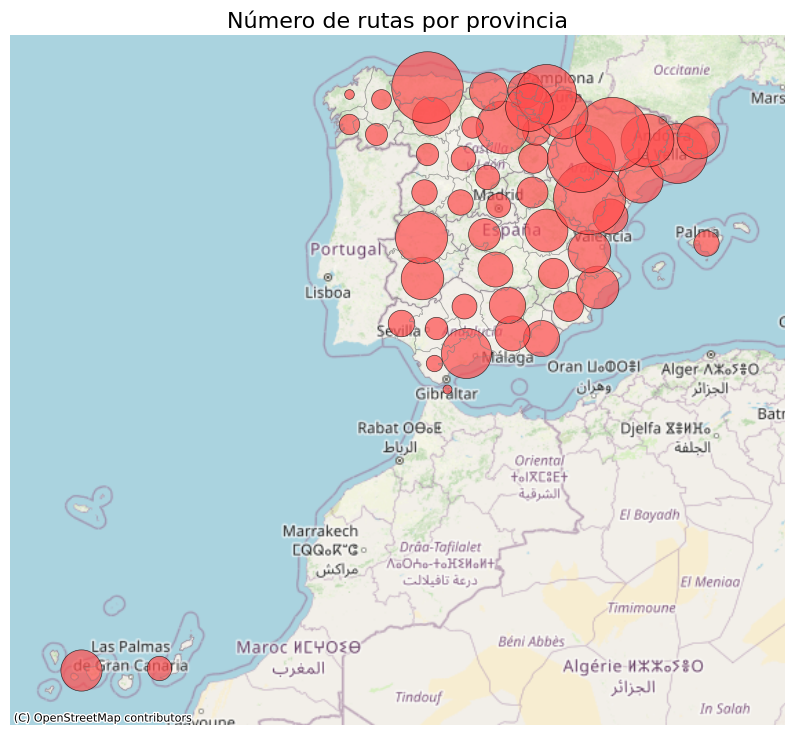

Mapa guardado en mapa_rutas_provincias.png


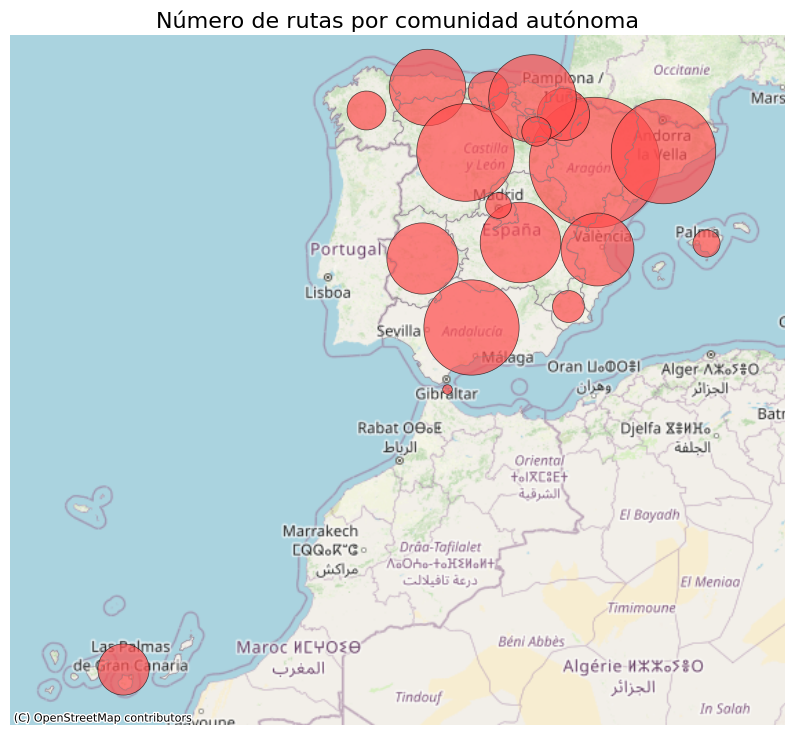

Mapa guardado en mapa_rutas_ccaa.png


In [29]:
# ----------------------------------------
# 4. Generar los dos mapas
# ----------------------------------------

# Mapa por provincias
generar_mapa(
    zonas_gdf=provincias,
    rutas_gdf=rutas_gdf,
    nombre_zona="rotulo",
    titulo="Número de rutas por provincia",
    output_file="mapa_rutas_provincias.png",
    escala_burbujas=7  # más pequeño que antes
)

# Mapa por comunidades
generar_mapa(
    zonas_gdf=ccaa,
    rutas_gdf=rutas_gdf,
    nombre_zona="rotulo",
    titulo="Número de rutas por comunidad autónoma",
    output_file="mapa_rutas_ccaa.png",
    escala_burbujas=8  # más grande, ya que hay menos CCAA
)
